<font size='6'>Volatility Clustering Generator</font>

<font size='5'>Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters.

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution.

<font size='5'>Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\huge D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states' mean/covariances factorize, 

$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states. This does not make a prediction, instead only <b>describes</b> the historical data and then resamples it using the state-transitioning Markov approach where the probability of resampling a given state should be proportional to it's posterior weight of occurrence in the fitted model.

In [11]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [12]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [54]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. Absolute value of the 1st-order differencing of the log price for each asset. View auto-correlation.

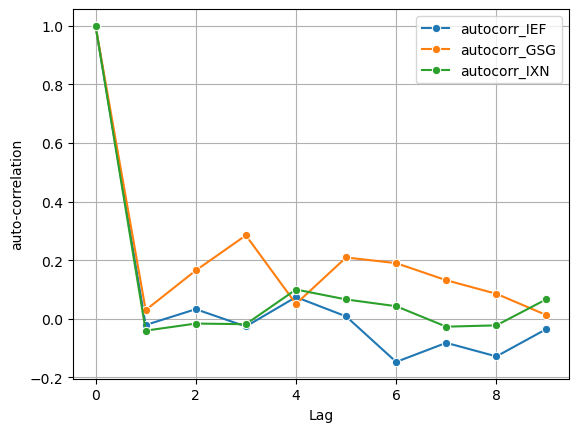

In [55]:
import scipy.stats as stats

# Log return absolute value 
m6_subset = m6_assets.copy().apply(np.log).apply(np.diff)

# Clean data 
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

# Shift GSG
m6_subset['GSG'] = m6_subset['GSG'].shift(-1)
m6_subset = m6_subset.dropna()

# View auto-correlation decay
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 10)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 10)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 10)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample len(m6_subset) separate individual draws from the variational model. This sampling should draw certain states in proportion to their weight in the posterior distribution. 

In [56]:
# Instantiate mixture model 
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=50)

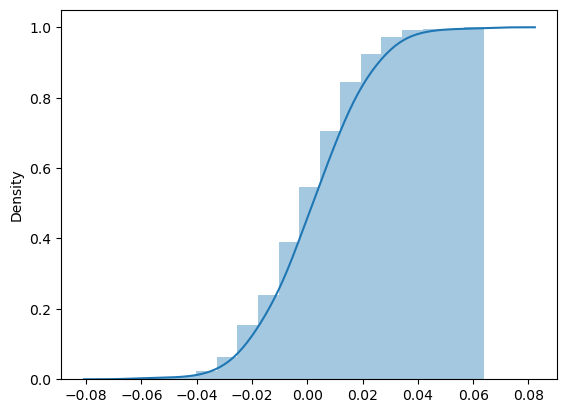

In [57]:
# Fit the model
dpgmm_model.fit(m6_subset)

# Sample len(m6_subset) from the generative model (Markov)
# Does not reproduce auto-correlation, only proportions of the variational states
samples, y = dpgmm_model.sample(225)

# Create dataframe
df = pd.DataFrame()
df['generated_IEF']=[ s[0] for s in samples ]
df['generated_GSG']=[ s[1] for s in samples ]
df['generated_IXN']=[ s[2] for s in samples ]

# Interpret as PDF 
sns.distplot(df['generated_GSG'].values, hist_kws={'cumulative':True}, kde_kws={'cumulative':True})
plt.show()

# Count the frequency of each latent state 
state_counts = np.zeros(num_components)
for M in y:
  state_counts[M] += 1 

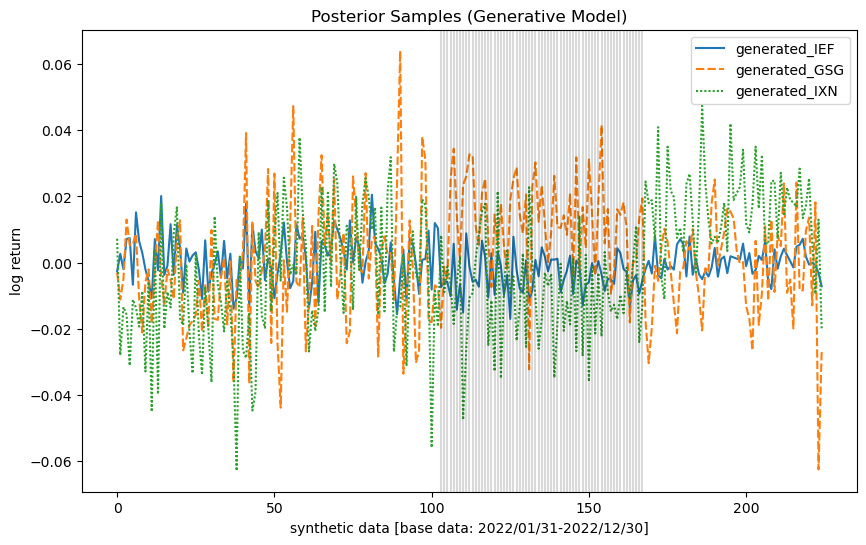

In [58]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(data=df, ax=ax)

for M in range(len(y)): 
  if y[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Posterior Samples (Generative Model)')
ax.set_ylabel('log return')
ax.set_xlabel(f'synthetic data [base data: 2022/01/31-2022/12/30]')
plt.show()

In [59]:
print(state_counts)
print(dpgmm_model.means_[np.argmax(state_counts)])

[ 1. 46. 56.  0. 65. 54.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0.00367396  0.01178117 -0.00719814]
